# GSE165388
## 05-2_estimate_dimensionality
---
### Before you start
- run codes in `05-1_gw*_extract_variablefeat.Rmd`

In [1]:
import glob
from itertools import product
import json
import os
import random
from typing import Dict, NamedTuple, List, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as si
import scipy.sparse as sp
from tqdm.notebook import tqdm

from sklearn.decomposition import TruncatedSVD

In [2]:
class Config(NamedTuple):
    mtx: List[str] = glob.glob("../../data/gse165388_variablefeat/*.mtx")
    save_dir: str = "../../out/gse165388/05_seurat_annot"
    fig_kwarg: Dict[str, Union[str, int, float]] = {
        'facecolor': 'white',
        'dpi': 300,
        'bbox_inches': 'tight',
        'pad_inches': 0.05
    }
    save_file: bool = False

In [3]:
conf = Config(save_file=True)

In [4]:
os.makedirs(conf.save_dir, exist_ok=True)

---
## Define funcs to use

In [5]:
def random_perm(coo, random_state):
    np.random.seed(random_state)
    coord = random.sample(
        list(
            product(
                np.arange(coo.shape[0]),
                np.arange(coo.shape[1])
            )
        ),
        len(coo.data)
    )
    
    row = np.array([v[0] for v in coord])
    col = np.array([v[1] for v in coord])
    
    np.random.seed(random_state)
    data = np.random.permutation(coo.data)
    
    return sp.coo_matrix((data, (row, col)), shape=coo.shape)

In [6]:
def parallel(coo, random_state):
    model1 = TruncatedSVD(n_components=coo.shape[0], random_state=random_state)
    model2 = TruncatedSVD(n_components=coo.shape[0], random_state=random_state)
    
    model1.fit_transform(coo.T)
    model2.fit_transform(random_perm(coo, random_state).T)
    
    return len(
        model1.explained_variance_[
            model1.explained_variance_ > model2.explained_variance_
        ]
    )

In [7]:
def plot_parallel(coo, random_state, ax):
    model1 = TruncatedSVD(n_components=coo.shape[0], random_state=random_state)
    model2 = TruncatedSVD(n_components=coo.shape[0], random_state=random_state)
    
    model1.fit_transform(coo.T)
    model2.fit_transform(random_perm(coo, random_state).T)
    
    dim = len(
        model1.explained_variance_[
            model1.explained_variance_ > model2.explained_variance_
        ]
    )

    ax.plot(model1.explained_variance_[:dim], c="r", linewidth=1)
    ax.plot(np.arange(dim, coo.shape[0]), model1.explained_variance_[dim:], c=".8", linewidth=1)
    ax.plot(model2.explained_variance_[dim:], c="k", linewidth=1, label="random permutation")
    
    ax.set(xlabel="Num. of components", ylabel="Variance", title=f"Parallel Analysis ({dim} components)")
    ax.legend()

---
## Estimate Dimensionality of the Data

In [8]:
conf.mtx

['../../data/gse165388_variablefeat/gw10feat_matrix.mtx',
 '../../data/gse165388_variablefeat/gw11feat_matrix.mtx',
 '../../data/gse165388_variablefeat/gw12feat_matrix.mtx',
 '../../data/gse165388_variablefeat/gw9feat_matrix.mtx']

In [9]:
name = [v.split("/")[-1].split("feat")[0] for v in conf.mtx]
name

['gw10', 'gw11', 'gw12', 'gw9']

In [10]:
l_data = [si.mmread(v) for v in conf.mtx]

Plot Prallel Analysis:   0%|          | 0/4 [00:00<?, ?it/s]

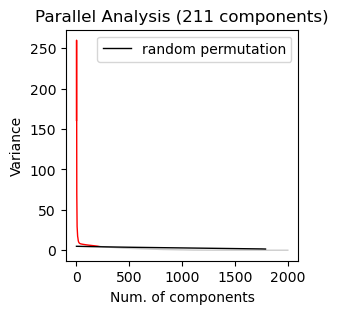

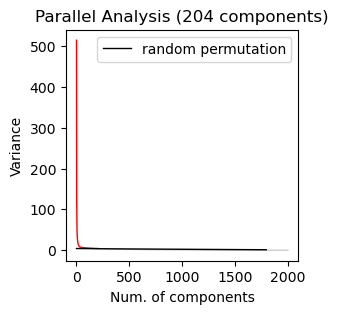

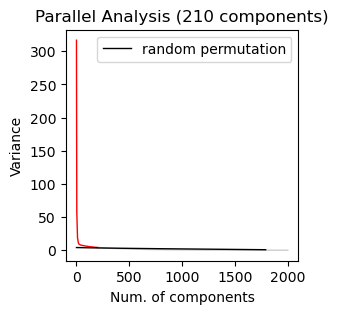

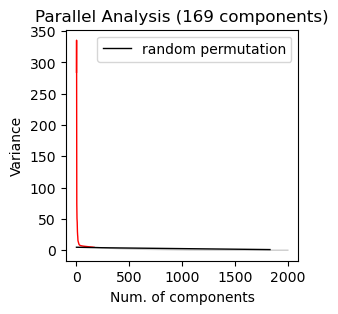

In [11]:
for (i, v), data_id in tqdm(zip(enumerate(l_data), name), desc="Plot Prallel Analysis", total=len(name)):
    fig, ax = plt.subplots(figsize=(3, 3))
    
    plot_parallel(v, random_state=0, ax=ax)
    
    if conf.save_file:
        plt.savefig(f"{conf.save_dir}/{data_id}_pa.png", **conf.fig_kwarg)

### Export as json

In [12]:
dims = {
    data_id: parallel(data, random_state=0) for data, data_id in zip(l_data, name)
}

In [14]:
with open(f"{conf.save_dir}/dimensionality.json", "w") as f:
    json.dump(dims, f)

In [15]:
dims

{'gw10': 211, 'gw11': 204, 'gw12': 210, 'gw9': 169}